In [2]:
from trafficSignNet import TrafficSignNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import datetime, os
import matplotlib
import pickle
%matplotlib inline

In [3]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)
    # loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))
		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]
		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)
        # resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))
	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
	# return a tuple of the data and labels
	return (data, labels)

In [4]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 500
INIT_LR = 1e-5
BS = 128
# load the label names
# labelNames = open("signnames.csv").read().strip().split("\n")[1:]
# labelNames = [l.split(",")[1] for l in labelNames]

In [5]:
# trainPath = "data/Train.csv"
# testPath = "data/Test.csv"
# basePath = "data"
# Load 
trainX = np.load("data/Xtrain.npy")
trainY = np.load("data/Ytrain.npy")
testX = np.load("data/Xtest.npy")
testY = np.load("data/Ytest.npy")

with open("classWeights.pk", 'rb') as f:
	classWeight = pickle.load(f)

# # load the training and testing data
# print("[INFO] loading training and testing data...")
# (trainX, trainY) = load_split(basePath, trainPath)
# (testX, testY) = load_split(basePath, testPath)
# # scale data to the range of [0, 1]
# trainX = trainX.astype("float32") / 255.0
# testX = testX.astype("float32") / 255.0
# # one-hot encode the training and testing labels
numLabels = len(trainY[0])
#print(numLabels)
# trainY = to_categorical(trainY, numLabels)
# testY = to_categorical(testY, numLabels)
# # calculate the total number of images in each class and
# # initialize a dictionary to store the class weights
# classTotals = trainY.sum(axis=0)
# classWeight = dict()
# # loop over all classes and calculate the class weight
# for i in range(0, len(classTotals)):
# 	classWeight[i] = classTotals.max() / classTotals[i]

In [6]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3,
	classes=numLabels)
# model.compile(loss="categorical_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])
# train the network
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

[INFO] compiling model...


In [7]:
model.compile(loss="categorical_crossentropy", optimizer=opt,
metrics=["accuracy"])
modelpath = "trafficNetNew.h5"
callback = [callbacks.ModelCheckpoint(
    modelpath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
),
# callbacks.EarlyStopping(patience=3),
callbacks.TensorBoard(log_dir='./logs', update_freq=1, histogram_freq=1)
]

In [8]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,callbacks=callback,
	verbose=1)

[INFO] training network...
Epoch 1/500
306/306 [==============================] - ETA: 0s - loss: 10.5976 - accuracy: 0.0334
Epoch 1: val_loss improved from inf to 3.91839, saving model to trafficNetNew.h5
306/306 [==============================] - 13s 40ms/step - loss: 10.5976 - accuracy: 0.0334 - val_loss: 3.9184 - val_accuracy: 0.0309
Epoch 2/500
306/306 [==============================] - ETA: 0s - loss: 9.3643 - accuracy: 0.0528
Epoch 2: val_loss improved from 3.91839 to 3.76092, saving model to trafficNetNew.h5
306/306 [==============================] - 29s 95ms/step - loss: 9.3643 - accuracy: 0.0528 - val_loss: 3.7609 - val_accuracy: 0.0465
Epoch 3/500
306/306 [==============================] - ETA: 0s - loss: 8.8648 - accuracy: 0.0743
Epoch 3: val_loss improved from 3.76092 to 3.63843, saving model to trafficNetNew.h5
306/306 [==============================] - 31s 100ms/step - loss: 8.8648 - accuracy: 0.0743 - val_loss: 3.6384 - val_accuracy: 0.0764
Epoch 4/500
306/306 [========

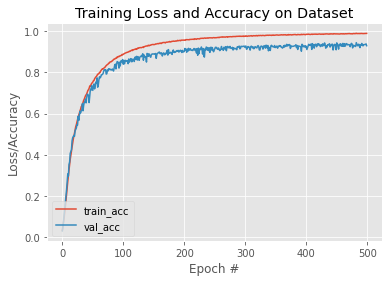

In [9]:
# plot the training loss and accuracy
%matplotlib inline
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, H.history["loss"], label="train_loss")
# plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("model_history")
plt.show()